# Meta Learners

In this tutorial, we are going to explore and compare different methods that leverage machine learning to estimate heterogeneous treatment effects.

For this tutorial, I assume you are familiar with the following concepts:

- Rubin's potential outcome framework
- Propensity score weighting
- Basic machine learning models

## Setting

We assume that for a set of i.i.d. subjects $i = 1, ..., n$ we observed a tuple $(X_i, D_i, Y_i)$ comprised of 

- a feature vector $X_i \in \mathbb R^n$
- a treatment assignment $T_i \in \lbrace 0, 1 \rbrace$
- a response $Y_i \in \mathbb R$

**Assumption 1 : unconfoundedness** (or ignorability, or selection on observables)

$$
\big \lbrace Y_i^{(1)} , Y_i^{(0)} \big \rbrace \ \perp \ T_i \ | \ X_i
$$

i.e. conditional on observable characteristics $X$, the treatment assignment $T$ is as good as random.

**Assumption 2: overlap** (or bounded support)

$$
\exists \eta > 0 \ : \ \eta \leq \mathbb E \left[ T_i = 1 \ \big | \ X_i = x \right] \leq 1-\eta
$$

i.e. no observation is deterministically assigned to the treatment or control group. 

## Meta Learners

### S-Learner

The simplest meta-algorithm is the single learner or **S-learner**. To build the S-learner estimator, we fit a single model for all observations.

$$
\mu(z) = \mathbb E \left[ Y_i \ \big | \ (X_i, T_i) = z \right]
$$

the estimator is given by the difference between the predicted values evaluated at $t=1$ and $t=0$.

$$
\hat \tau_{S} (x) = \hat \mu(x,1) - \hat \mu(x,0)
$$

**Problems**

- We are learning a single model so we hope that the model uncovers heterogeneity in $T$ but it might not be the case
- If the model is heavily regularized because of the high dimensionality of $X$, it might not recover any treatment effect
    - e.g. with trees, it might not split on $T$

### T-learner

To build the two-learner or **T-learner** estimator, we fit two different models, one for treated units and one for control units.

$$
\mu^{(1)}(x) = \mathbb E \left[ Y_i \ \big | \ X_i = x, T_i = 1 \right] \qquad ; \qquad \mu^{(0)}(x) = \mathbb E \left[ Y_i \ \big | \ X_i = x, T_i = 0 \right]
$$

the estimator is given by the difference between the predicted values of the two algorithms.

$$
\hat \tau_{T} (x) = \hat \mu^{(1)}(x) - \hat \mu^{(0)}(x)
$$

**Problems**

- We are using just a fraction of the data for each prediction problem
    - S-learner was using all the data
- We might get heterogeneity where there is none, just because we are forcing different models
    - E.g. if trees split differently, to compute the two potential outcomes we use different populations

### X-learner

The cross-learner or **X-learner** estimator is an extension of the T-learner estimator. It is built in the following way:

1. As for the T-learner, compute separate models for $\mu^{(1)}(x)$ and $\mu^{(0)}(x)$ using the treated and control units, respectively

2. Compute the estimated treatment effects as

$$
\Delta_i (x) = 
\begin{cases}
Y_i - \hat \mu^{(0)}(x) &\quad \text{ if } T_i = 1
\newline
\hat \mu^{(1)}(x) - Y_i &\quad \text{ if } T_i = 0
\end{cases}
$$

3. Predicting $\Delta$ from $X$, compute $\hat \tau^{(0)}(x)$ from treated units and  $\hat \tau^{(1)}(x)$ from control units

4. Estimate $e(x) = \mathbb E \left[ T_i = 1 \ \big | \ X_i = x \right]$

5. Compute 

$$
\hat \tau_X(x) = \hat \tau^{(0)}(x) \hat e(x) + \hat \tau^{(1)}(x) (1 - \hat e(x))
$$

## Example

In this example, we are going to use the following **data generating process**

- $N = 4000$
- $p = 10$
- $X_i \sim N(0, I_p)$
- $e(x) = 0.3$ 
- $\varepsilon_i \sim N(0, 1)$
- $\mu^{(0)}(x) = (x_1 + x_2)_{+} + \varepsilon$
- $\mu^{(1)}(x) = (x_1 + x_2)_{+} + \frac{1}{1 + e^{-x_3}} + \varepsilon$

So that the propensity score is constant $e(x) = 0.3$, the treatment effect is $\frac{1}{1 + e^{-x_3}}$ and the average treatment effect is $0.5$.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *
from src.dgp import dgp4

We generate a dataset out of our DGP.

In [3]:
dgp = dgp4()
df = dgp.generate_data()
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,e,T,tau,Y
0,1.624345,-0.611756,-0.528172,-1.072969,0.865408,-2.301539,1.744812,-0.761207,0.319039,-0.249370,0.3,0,0.370943,1.116502
1,1.462108,-2.060141,-0.322417,-0.384054,1.133769,-1.099891,-0.172428,-0.877858,0.042214,0.582815,0.3,0,0.420087,-0.248671
2,-1.100619,1.144724,0.901591,0.502494,0.900856,-0.683728,-0.122890,-0.935769,-0.267888,0.530355,0.3,0,0.711276,0.651441
3,-0.691661,-0.396754,-0.687173,-0.845206,-0.671246,-0.012665,-1.117310,0.234416,1.659802,0.742044,0.3,0,0.334662,-0.913644
4,-0.191836,-0.887629,-0.747158,1.692455,0.050808,-0.636996,0.190915,2.100255,0.120159,0.617203,0.3,0,0.321441,0.121779


First, we implement the simplest machine learning method for learning heterogeneous treatment effects: the **S-learner**. 

We fit a single `RandomForestRegressor` method to all the data.

In [4]:
from sklearn.ensemble import RandomForestRegressor as rfr

mu_S = rfr(min_samples_leaf=30)
mu_S.fit(df[dgp.X + ['T']], df['Y']);

Then, we use it to predict $\mu^{(1)}(x)$ and $\mu^{(0)}(x)$.

In [5]:
df['hat_mu0_S'] = mu_S.predict(df[dgp.X + ['T']].assign(T=0))
df['hat_mu1_S'] = mu_S.predict(df[dgp.X + ['T']].assign(T=1))

We estimate the average treatment effect as the difference between the two predictions.

In [6]:
df['hat_tau_S'] = df['hat_mu1_S'] - df['hat_mu0_S']
print(f"S-learner estimate : {np.mean(df['hat_tau_S']):.4}")

S-learner estimate : 0.3657


How close are we to the true treatment effect?

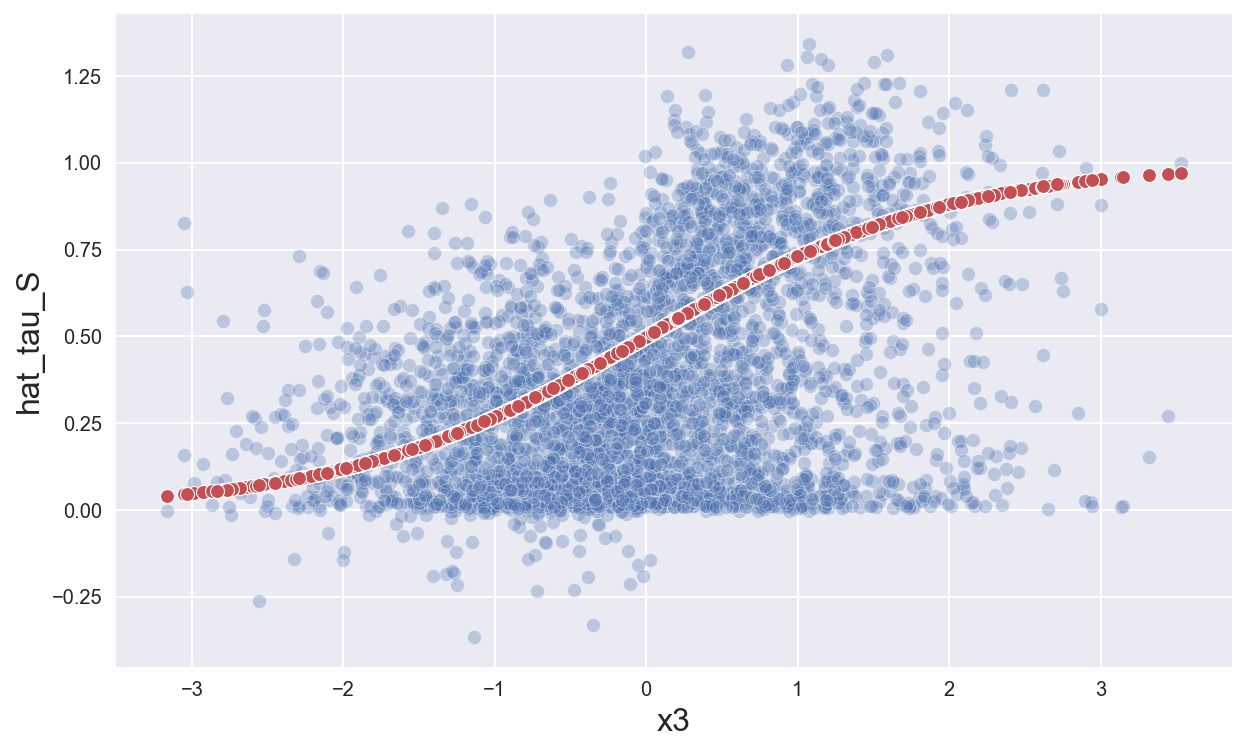

In [7]:
sns.scatterplot(data=df, x='x3', y='hat_tau_S', alpha=0.3);
sns.scatterplot(data=df, x='x3', y='tau', color='C2');

The **T-learner** method instead fits different model for treated and control units. The advantage is that it can 

In [8]:
mu0_T = rfr(min_samples_leaf=30)
mu0_T.fit(df.loc[df['T']==0, dgp.X + ['T']], df.loc[df['T']==0, 'Y'])
mu1_T = rfr(min_samples_leaf=30)
mu1_T.fit(df.loc[df['T']==1, dgp.X + ['T']], df.loc[df['T']==1, 'Y']);

Then, we use it to predict $\mu^{(1)}(x)$ and $\mu^{(0)}(x)$.

In [9]:
df['hat_mu0_T'] = mu0_T.predict(df[dgp.X + ['T']])
df['hat_mu1_T'] = mu1_T.predict(df[dgp.X + ['T']])

We estimate the average treatment effect as the difference between the two predictions.

In [10]:
df['hat_tau_T'] = df['hat_mu1_T'] - df['hat_mu0_T']
print(f"S-learner estimate : {np.mean(df['hat_tau_T']):.4}")

S-learner estimate : 0.5231


We can plot the distribution of treatment effect estimates against the true values.

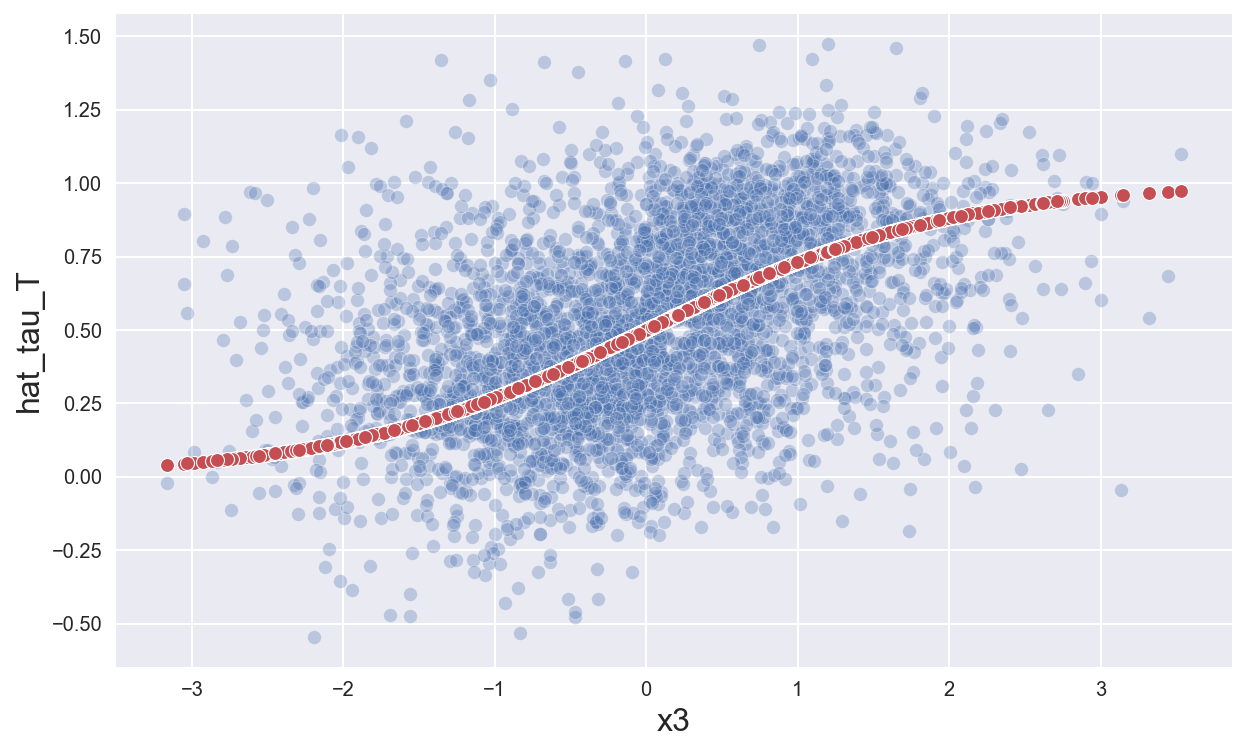

In [11]:
sns.scatterplot(data=df, x='x3', y='hat_tau_T', alpha=0.3);
sns.scatterplot(data=df, x='x3', y='tau', color='C2');

Let's now estimate the **X-learner**. The first step is exactly the same as for the T-learner: estimate $\hat \mu^{(1)}(x)$ and $\hat \mu^{(0)}(x)$ using the treated and control group, respectively.

Afterwards, we compute the estimated treatment effect on the treated using the the estimated counterfactual outcome estimated on the control group $\hat \mu^{(0)}(x)$, and viceversa.

In [12]:
df['Delta'] = 0
df.loc[df['T']==0, 'Delta'] = (df['hat_mu1_T'] - df['Y'])[df['T']==0]
df.loc[df['T']==1, 'Delta'] = (df['Y'] - df['hat_mu0_T'])[df['T']==1]

Then, we basically repeat the process for the T-learner, but using Delta as outcome variable.

In [13]:
tau0_X = rfr(min_samples_leaf=30)
tau0_X.fit(df.loc[df['T']==0, dgp.X + ['T']], df.loc[df['T']==0, 'Delta'])
tau1_X = rfr(min_samples_leaf=30)
tau1_X.fit(df.loc[df['T']==1, dgp.X + ['T']], df.loc[df['T']==1, 'Delta']);

In [14]:
df['hat_tau0_X'] = tau0_X.predict(df[dgp.X + ['T']])
df['hat_tau1_X'] = tau1_X.predict(df[dgp.X + ['T']])

Finally, we estimate the propensity score.

In [15]:
from sklearn.linear_model import LogisticRegression as lr

df['hat_e'] = lr().fit(df[dgp.X], df['T']).predict_proba(df[dgp.X])[:,1]

Now we can compute the **X-learner estimate** as

In [16]:
df['hat_tau_X'] = df['hat_e'] * df['hat_tau0_X'] + (1-df['hat_e']) * df['hat_tau1_X']
print(f"X-learner estimate : {np.mean(df['hat_tau_X']):.4}")

X-learner estimate : 0.5253


We can plot the distribution of treatment effect estimates against the true values.

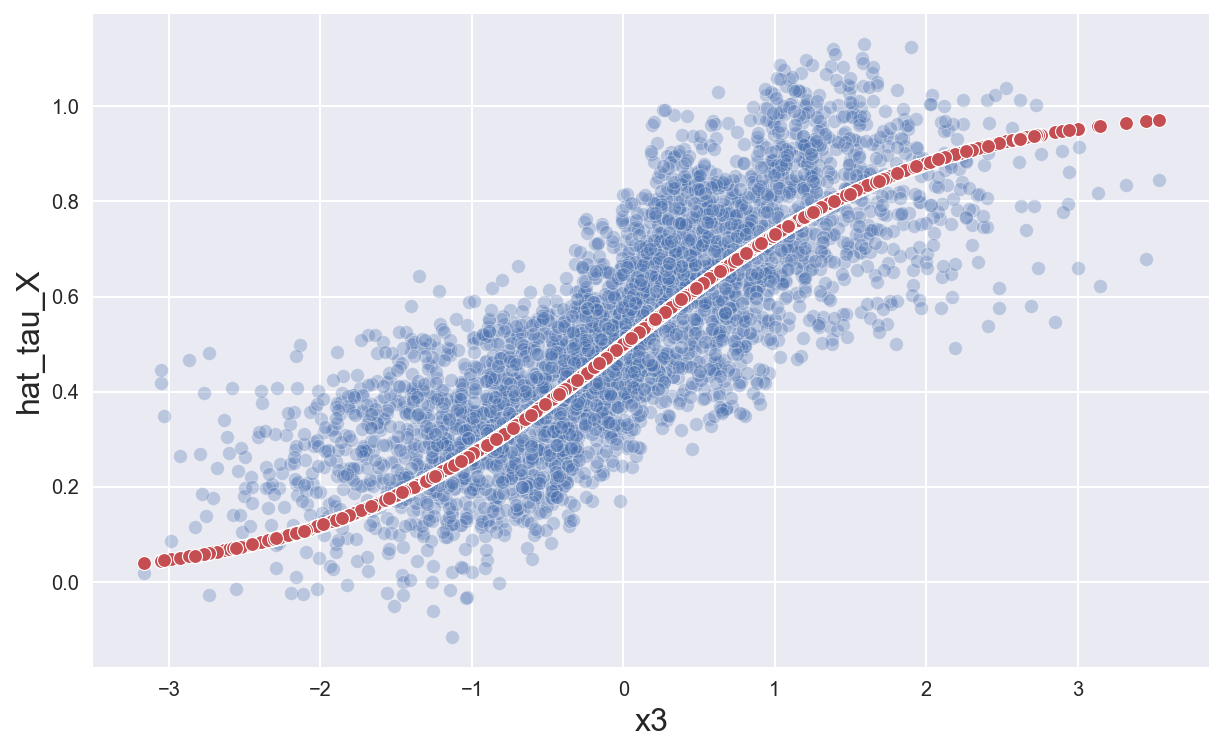

In [17]:
X_plot = sns.scatterplot(data=df, x='x3', y='hat_tau_X', alpha=0.3);
sns.scatterplot(data=df, x='x3', y='tau', color='C2');

The X-learner estimator is heavily superior to both the S-learner and the T-learner. This is particularly evident if we combine all the plots.

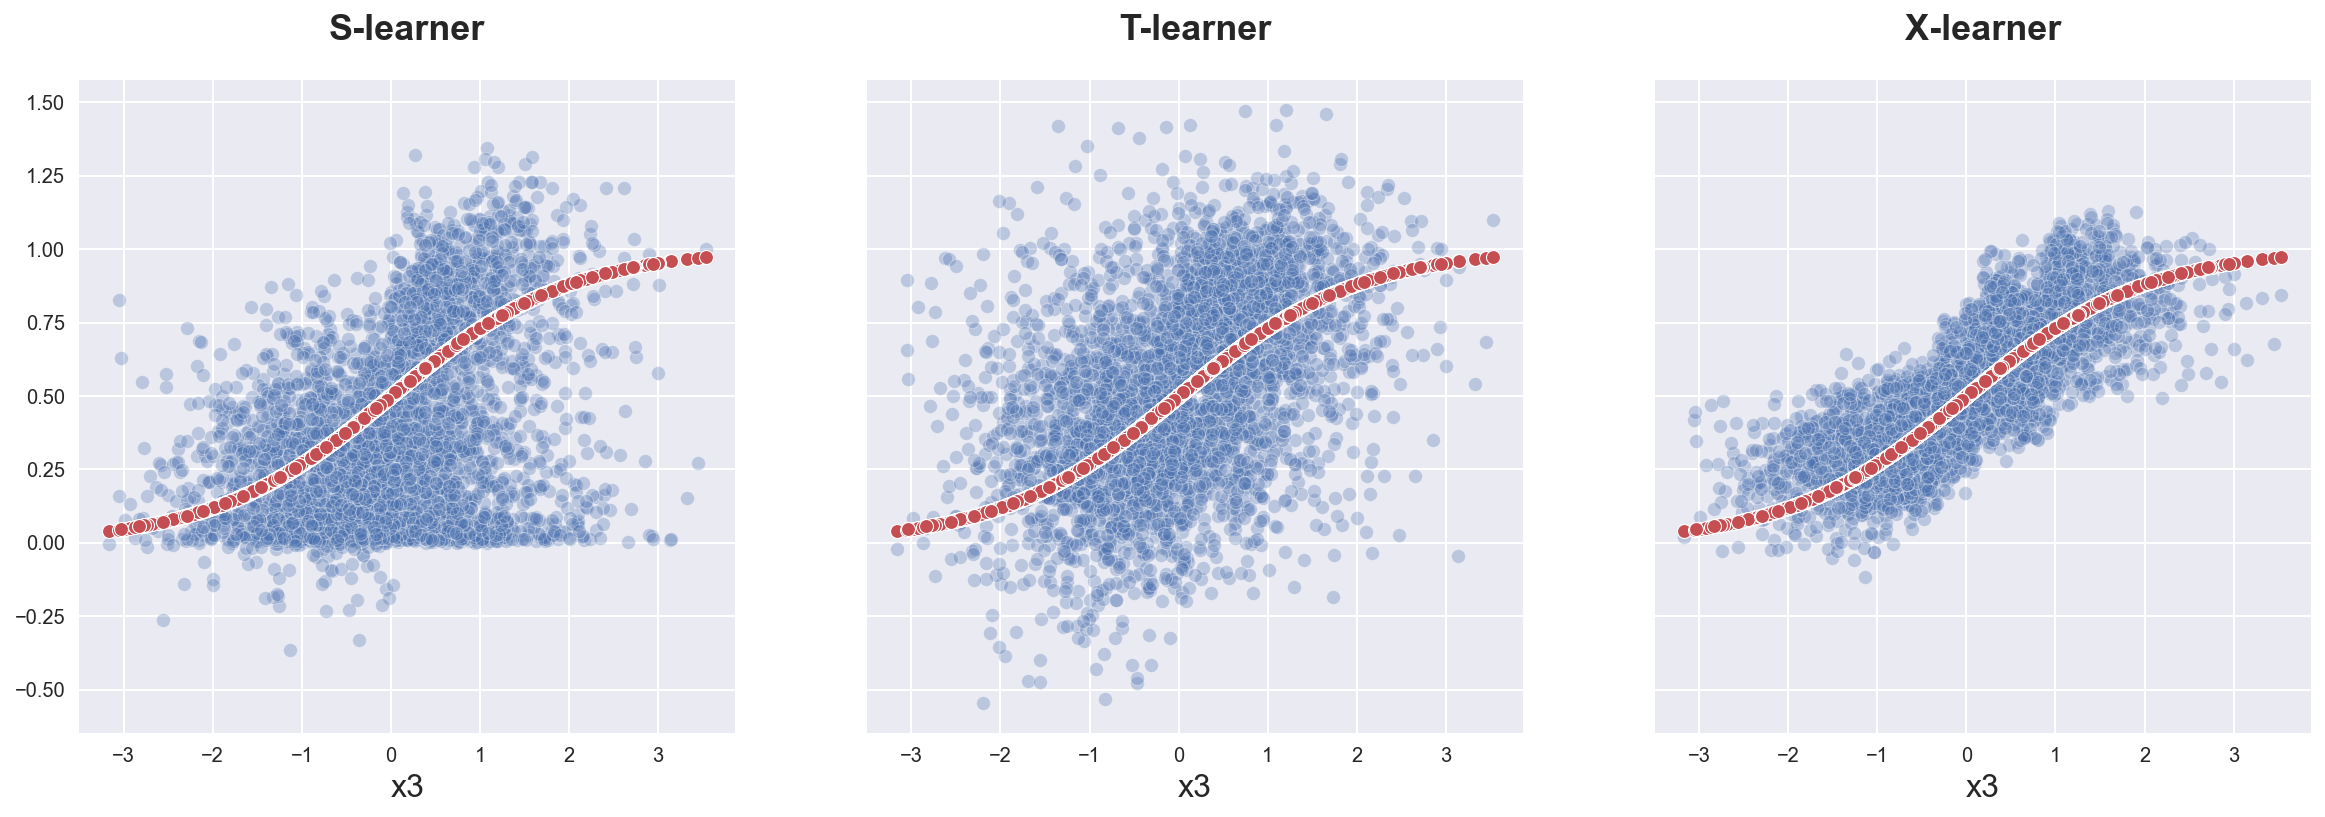

In [18]:
fig, axs = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,6))
for i, l in enumerate(['S', 'T', 'X']):
    sns.scatterplot(data=df, x='x3', y=f"hat_tau_{l}", alpha=0.3, ax=axs[i]);
    sns.scatterplot(data=df, x='x3', y='tau', color='C2', ax=axs[i]).\
    set(title=f"{l}-learner", ylabel='');

## References

- Meta learners: [Metalearners for estimating heterogeneous treatment effects using machine learning](https://www.pnas.org/doi/abs/10.1073/pnas.1804597116) (2019) by Künzel, Sekhon, Bickel, and Yu
- Taxonomy of methods: [Recursive partitioning for heterogeneous causal effects](https://www.pnas.org/doi/abs/10.1073/pnas.1510489113) (2016) by Athey and Imbens
- [Video lecture](https://www.youtube.com/watch?v=N9ThAs7NS0g) by Stefan Wager (Stanford)